# Análisis y preprocesamiento de *la diara*

In [1]:
import re
import json
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup
# from tqdm import tqdm
from tqdm.auto import tqdm

### Cargo el dataset

In [2]:
f = open('/home/jp/Workspace/pln/notebooks/preproc/Latest20k.json')
data = json.loads(f.read())

### Estrctura del dataset LaDiaria

* Consta de 20_000 artículos
* Cada uno con los atributos `html` y `slug`
* El `html` es el artículo en sí
* Mientras que `slug` es el identificador ASCII (puro) usado como *path* en la URL. Se relaciona con la etiqueta `<title>`


In [3]:
len(data), type(data), list(data.keys())

(1, dict, ['articles'])

In [4]:
type(data['articles']), len(data['articles'])

(list, 20000)

In [5]:
type(data['articles'][0]), list(data['articles'][0].keys())

(dict, ['html', 'slug'])

In [6]:
data['articles'][0]['html'][:200]

'<!DOCTYPE html><html lang="es-uy"><head>  <meta http-equiv="Content-Type" content="text/html; charset=utf-8">  <title>Avión iraní “no ingresó” al espacio aéreo uruguayo por orden de Defensa</title></h'

In [7]:
data['articles'][0]['slug']

'avion-irani-no-ingreso-al-espacio-aereo-uruguayo-por-orden-de-defensa'

Todos los artículos siguen este patron?

In [8]:
follows_pattern = lambda a: len(a.keys()) == 2 and set(a.keys()) == {'html', 'slug'}

all(follows_pattern(a) for a in data['articles'])

True

Entonces se puede simplificar la estructura

In [9]:
data = [a.get('html') for a in data['articles']]

In [10]:
type(data), len(data), type(data[0])

(list, 20000, str)

Cierro el archivo

In [11]:
f.close()

## Análisis sintáctico del HTML de los artículos de La Diaria

Observaciones:

* Todos los articulos siguen la siguiente estructura:
    - Cabezal
    - Fecha | Categoría | Copyright de fotos (opcional. e.g., #3)
    - Subtítulo
    - El artículo
    - Pie de página (opcional. e.g., #3)
* Hay links
* Hay imágenes
* Hay etiquetas `<em>` que se renderizan como itálicas (e.g., #3 ""). E.g., en el artículo #5 se puede leer `Ray Dalío, en su libro <em>Principios para entender el cambio del orden mundial</em> esboza interesantes...`
* Hay fechas (e.g., #3 "16/3/2022")
* "-" son usados como paréntesis. (e.g., #3)
* Aunque también hay paréntesis curvos. A veces usados con el mismo sentido que `-` pero otras veces son usados para referenciar imágenes (e.g., "(ver recuadro y gráfico 1)" #3)
* dentro de `div.article-body` se pueden encontrar:
    - párrafos `<p>` donde el primero viene seguido de un `<strong>` y dentro de este se encuentra una sintesis del artículo completo.
    - cabezales `h3` y `h4`
    - comillas NO-ASCII `“` `”` !
    - a veces tambien es posible encontrar 
    - `.extension` que simboliza una especie de mini-artículo
        - `h3.extension__title`
        - `div.extension__body`
            - `<p>`
    - `div.inline-image-wrap figure picture`
        - `source`
        - `img`
    - algunos `<p>` termina en `:` y viene acompanados de una imagen como el punto anterior
    - listas de la forma `<ul> <li> <p>`
    - en pie de página a veces se puede encontrar un `<blockquote>` (e.g., #7) que dice que el artículo ha sido adaptado o traducido al español de tal o cual fuente (junto con un `<a>`). A veces (e.g., #8), también se usa un `div.footnote` (seguido de un `<hr>` y una lista `<ol>`)
    - supraíndices (e.g., #8) `<sup>`
    - el artículo #8 representa un caso particular donde las referencias del mismo vienen seguidas de un `<p>` a pie de página; hecho que hace difícil diferenciar entre texto (conteido) y referencias.
    - en el artículo #13 incluso se puede encontrar embebido un reporoducto de Spotify `div.extension div.extension__body div iframe`
    - en el artículo #13235 incluso se puede encontrar embebido un tweet `div.extension div.extension__body`
    - el artículo #15 termina con ` <p><em>Ivonne Calderón es historiadora colombiana.</em></p>` En principio, no hay forma de distringuirlo del resto del texto
    - algunos artículos NO tienen categoría asignada. (e.g., #6027)
    - algunos artículos consisten únicamente de una sola foto. (e.g., #289, #290, #292)
    - en *la diaria* es común que en sus artículos pongan links a otras noticias "*relativamente*" relacionadas. (e.g., #78, #113, #120). Resulta que se trata de un `<ul>` (lista) de un único elemento `<p>` (párrafo) y siempre con prefijo "*Leé más sobre esto*".
    - el artículo #6683 es el único que (presuntamente por error) tiene un `<code>`.

### Renderizador de noticias

In [12]:
ix = 0

In [13]:
# ix = 15 - 1
# ix = 21 - 1
# ix = 289 - 1
# ix = 6683 - 1   # cotiene <code />
# ix = 13232 - 1
ix = 13235 - 1 # cotiene tuit
# ix = 15715 - 1 # contiene footnote + equacion embebida en img

In [14]:
ix += 1
print(ix)
doc = data[ix]
display(HTML(data[ix]))

13235


### Depurador HTML

In [15]:
print(BeautifulSoup(doc, 'html.parser').prettify())

<!DOCTYPE html>
<html lang="es-uy">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   Cerca de 1.000 voluntarios participan en estudio posvacunas del MSP
  </title>
 </head>
 <body>
  <div class="article-header">
   <h1 class="article-title after_foto">
    Cerca de 1.000 voluntarios participan en estudio posvacunas del MSP
   </h1>
   <div class="article-date-author">
    <span class="date small">
     <time datetime="2021-06-15T15:15:01">
      15 De Junio De 2021
     </time>
     |
    </span>
    <span class="small">
     <a href="/seccion/coronavirus/">
      Coronavirus
     </a>
    </span>
    <span class="small">
     | Foto:        Alessandro Maradei
    </span>
   </div>
  </div>
  <div class="article-body paywalled-content">
   <p>
    El Ministerio de Salud Pública (MSP) comenzó este lunes una investigación sobre la formación de anticuerpos para SARS-CoV-2 en las personas ya inmunizadas con ambas dosis de las vacunas contra el cor

### Análisis sobre la distribución de las categoría de los artículos

Se observa que:
 - Hay 14 artículos SIN categoría
 - Hay únicamente 4 categorías (directamente) relacionadas con el COVID:
     - `coronavirus` (821)
     - `coronavirus-en-uruguay` (151)
     - `coronavirus-en-el-mundo` (18)
     - `ciencia-y-coronavirus` (1)
 - En total hay tan solo **991** artículos etiquetados con alguna de estas 4 categorías (i.e., ~ 5% del dataset)
 - En total hay **4,471** artículos que mencionan al menos una vez "coronavirus", "COVID" o "SARS-CoV-2" (i.e., ~ 22% del dataset)
 - De los artículos que mencionan al COVID pero no estan etiquetados con niguna de las 4 cateogrías relacionado al COVID:
     - Se distribuyen entre 123 categorías diferentes (lo que implica una cobertura del ~ 80% sobre todas cateogrías posibles; por lo tanto, un 20% de las categorías no menciona ni siquiera una sola vez al coronavirus/COVID en **NIGUNO** de sus artículos)
     - Las categorías que más mencionan al COVID son: `politica-nacional`, `politica-internacional`, `futbol`, `humor` y  `posturas`
     - Los artículos de `humor` tienen alto contenido no solo de **información falsa** (ya que frecuentemente se redactan a modo de burla) sino tambien de **odio**
     - Los artículos de `futbol` estan muy vagamente relacionados al COVID. Cuando lo mencionan generalmente es para aclarar que alguna fecha queda postergada o para informar que algún jugador/a murió.

In [16]:
# funciones auxiliares
get_hdr_links   = lambda doc: BeautifulSoup(doc).select('div.article-header div.article-date-author a')
is_cat_link     = lambda a: "seccion" in a.get("href")
get_cat_link    = lambda d: next(iter([a.get("href") for a in get_hdr_links(d) if is_cat_link(a)]), "0")
get_cat         = lambda link: next(l for l in link.split("/")[::-1] if len(l) > 0)

In [17]:
dist = dict()
for d in tqdm(data):
    cat = get_cat(get_cat_link(d))
    if cat not in dist:
        dist[cat] = 0
    dist[cat] += 1

  0%|          | 0/20000 [00:00<?, ?it/s]

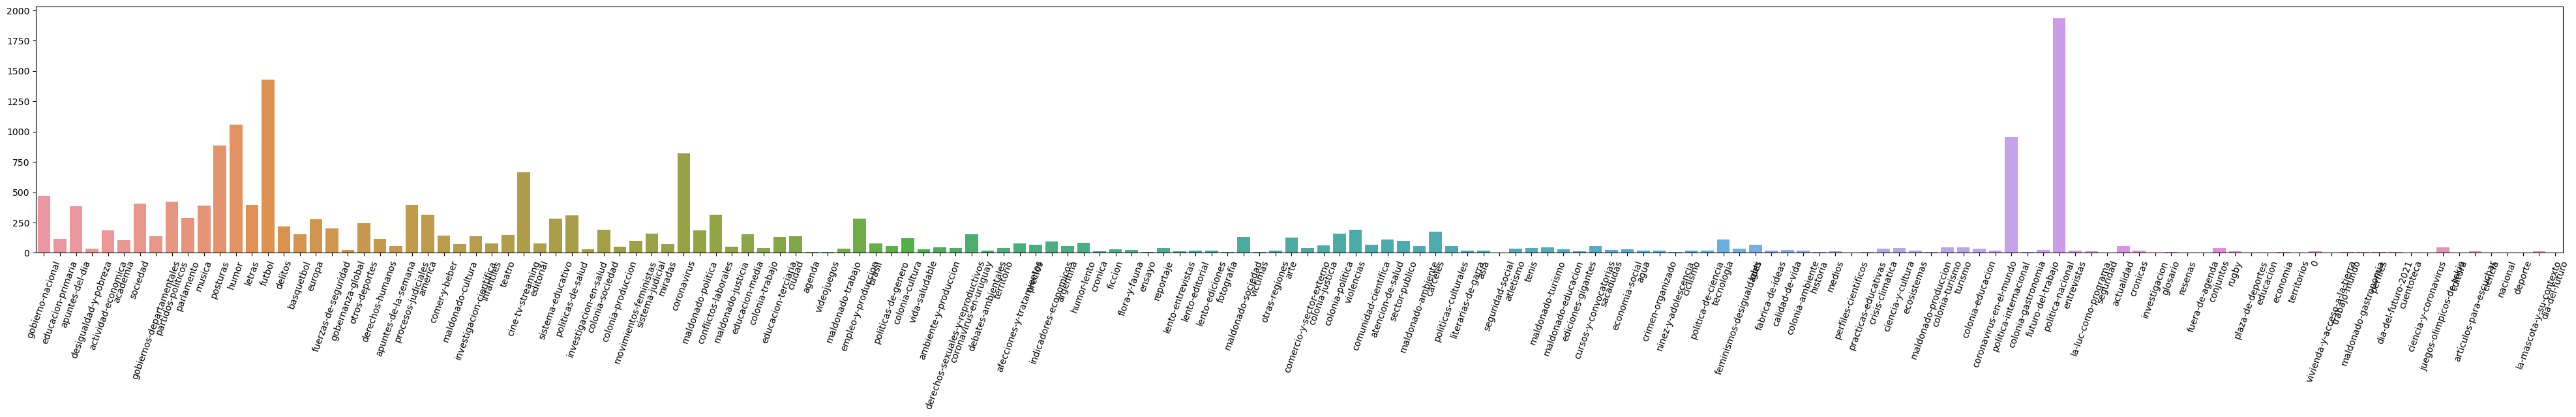

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(50, 5), dpi=100)
sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=ax)
plt.xticks(rotation=70)
plt.show()
# plt.tight_layout()

In [19]:
dist

{'gobierno-nacional': 470,
 'educacion-primaria': 116,
 'apuntes-del-dia': 387,
 'desigualdad-y-pobreza': 37,
 'actividad-economica': 184,
 'academia': 102,
 'sociedad': 407,
 'gobiernos-departamentales': 135,
 'partidos-politicos': 423,
 'parlamento': 290,
 'musica': 389,
 'posturas': 886,
 'humor': 1056,
 'letras': 393,
 'futbol': 1427,
 'delitos': 220,
 'basquetbol': 153,
 'europa': 277,
 'fuerzas-de-seguridad': 201,
 'gobernanza-global': 23,
 'otros-deportes': 245,
 'derechos-humanos': 114,
 'apuntes-de-la-semana': 55,
 'procesos-judiciales': 393,
 'america': 316,
 'comer-y-beber': 143,
 'maldonado-cultura': 75,
 'investigacion-cientifica': 136,
 'infantiles': 80,
 'teatro': 149,
 'cine-tv-streaming': 665,
 'editorial': 78,
 'sistema-educativo': 285,
 'politicas-de-salud': 311,
 'investigacion-en-salud': 27,
 'colonia-sociedad': 191,
 'colonia-produccion': 51,
 'movimientos-feministas': 101,
 'sistema-judicial': 161,
 'miradas': 75,
 'coronavirus': 821,
 'maldonado-politica': 188,


In [20]:
len(dist)

158

In [21]:
sum([v for k,v in dist.items()])

20000

In [22]:
# articulos que mencionan "coronavirus"
menciona_covid = lambda doc: "coronavirus" in doc or "covid" in doc or "SARS-CoV-2" in doc

sum([1 for d in tqdm(data[:]) if menciona_covid(d)])

  0%|          | 0/20000 [00:00<?, ?it/s]

4471

In [23]:
# articulos que mencionan "coronavirus" que no estan tageados con una de las 4 categorias de covid
covid_cats = ['coronavirus','coronavirus-en-uruguay','coronavirus-en-el-mundo','ciencia-y-coronavirus']
dist2 = dict()

for d in tqdm(data):
    if not menciona_covid(d): continue;
    cat = get_cat(get_cat_link(d))
    if cat in covid_cats: continue;
    if cat not in dist2:
        dist2[cat] = 0
    dist2[cat] += 1
    
dist2

  0%|          | 0/20000 [00:00<?, ?it/s]

{'actividad-economica': 46,
 'gobernanza-global': 8,
 'apuntes-de-la-semana': 31,
 'letras': 23,
 'editorial': 28,
 'sistema-educativo': 85,
 'gobierno-nacional': 54,
 'politicas-de-salud': 146,
 'posturas': 209,
 'educacion-primaria': 44,
 'conflictos-laborales': 69,
 'parlamento': 21,
 'humor': 218,
 'europa': 23,
 'empleo-y-produccion': 102,
 'vida-saludable': 6,
 'derechos-sexuales-y-reproductivos': 6,
 'brasil': 17,
 'partidos-politicos': 21,
 'precios': 6,
 'academia': 20,
 'america': 44,
 'lento-entrevistas': 4,
 'lento-editorial': 6,
 'investigacion-cientifica': 35,
 'sociedad': 30,
 'afecciones-y-tratamientos': 49,
 'apuntes-del-dia': 118,
 'carceles': 29,
 'futbol': 182,
 'educacion-terciaria': 22,
 'gobiernos-departamentales': 9,
 'maldonado-turismo': 14,
 'musica': 40,
 'cine-tv-streaming': 53,
 'politica-de-ciencia': 6,
 'comunidad-cientifica': 27,
 'reportaje': 14,
 'practicas-educativas': 3,
 'maldonado-justicia': 7,
 'maldonado-educacion': 4,
 'sector-publico': 26,
 'ma

- futbol
- basquetbol
- ciclismo
- otros-deportes
- rugby
- atletismo
- tenis
- deporte
- literarias-de-garra
- juegos-olimpicos-de-tokio

- fotografia
- arte
- cuentoteca
- lento-ediciones
- sacadudas
- miradas

In [24]:
len(dist2), sum([v for k,v in dist2.items()])

(123, 3480)

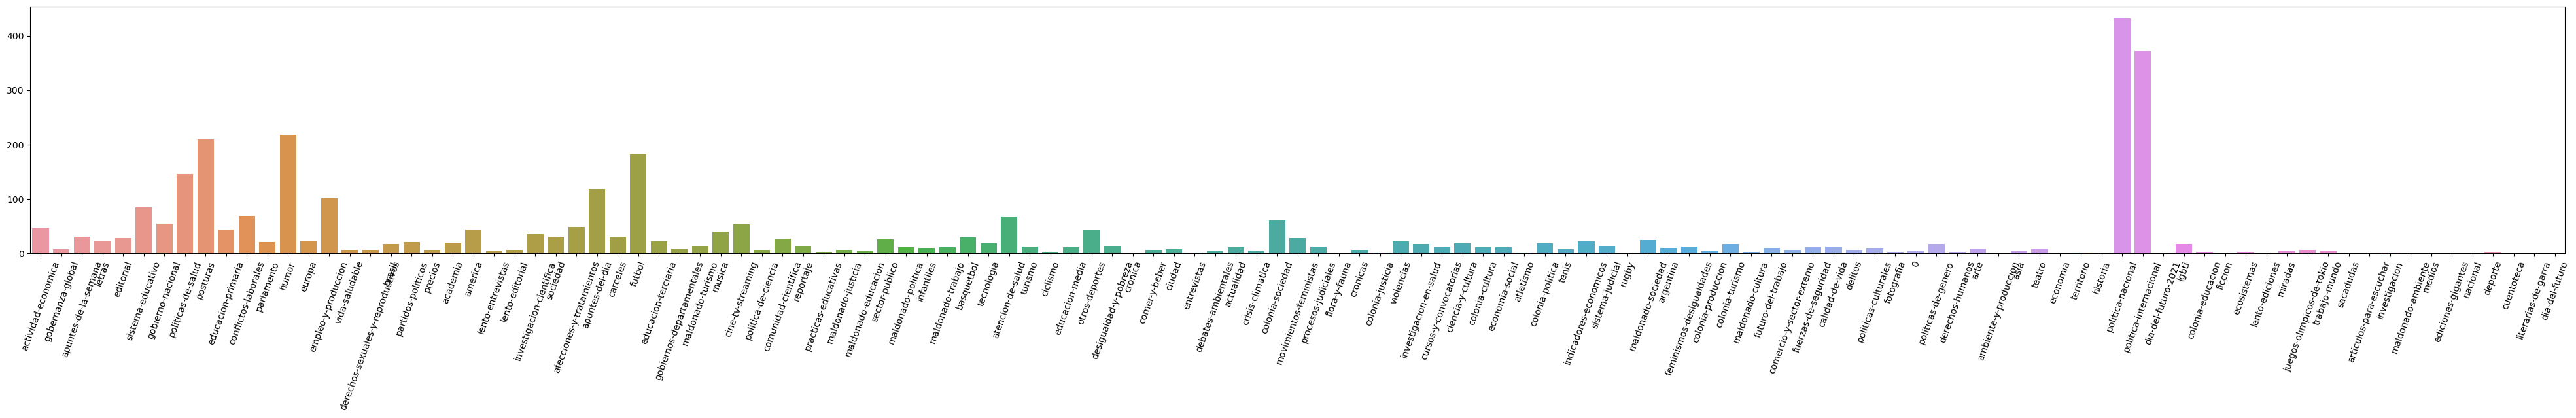

In [25]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(50, 5), dpi=100)
sns.barplot(x=list(dist2.keys()), y=list(dist2.values()), ax=ax)
plt.xticks(rotation=70)
plt.show()
# plt.tight_layout()

### Filtrado de noticias

En particular se inspeccionana aquellos artículos cuya categoría sea "humor" y mencione al covid.

In [140]:
# funcion de alto orden. retorna una funcion booleana que 
# retorna `true` si el doc `d` es de la categoria `cat`
# si `cat` es el string vacio, o el caracter "*" tambien 
# retorna `true`
def is_of_cat(cat):
    def of_cat(d):
        links = [a.get("href") for a in get_hdr_links(d) if is_cat_link(a)]
        c = get_cat(links[0]) if len(links) == 1 else str(len(links))
        return c == cat or cat in ["", "*"]
    return of_cat

# must     = lambda d: all(f(d) for f in [menciona_covid, is_of_cat('humor')])
must     = lambda d: all(f(d) for f in [is_of_cat('sacadudas')])
filtered = iter((i,d) for i,d in enumerate(tqdm(data)) if must(d))

  0%|          | 0/20000 [00:00<?, ?it/s]

In [141]:
fid, fdoc = next(filtered)
print(fid)
display(HTML(fdoc))

945


.

.

.

.

.

.

.

.

.

.

.


## Curación

- Se eliminan todo lo que no quede definido dentro de `div.article-body`
- Se eliminan los `div.extension`
- Se eliminan las imágenes
- Se eliminan los superíndice
- Se eliminan los separadores horizontales
- Se eliminan las tablas
- Si el último hijo es una lista o un `div.footnote` se elimina
- Se eliminan los links de tipo "leé más en..."

In [28]:
# auxiliares
get_tags     = lambda el: [tag.name for tag in el.find_all()]
get_children = lambda el: el.findChildren(recursive=False)
last_child   = lambda cs: cs[-1] if cs else None
_is          = lambda el, tagname: el.name == tagname
has_class    = lambda el, cl: el != None and el.get("class") and cl in el.get("class")

In [29]:
curated = []
cat_blacklist = ['humor', 'humor-lento','0'] # '0' representa "sin categoria"

for d in tqdm(data[:]):
    
    if get_cat(get_cat_link(d)) in cat_blacklist:
        curated.append(None)
        continue
    
    # 1. body-only
    a = BeautifulSoup(d).select_one('div.article-body')
    
    # 2. se eliminan los embebidos
    for el in a.select('div.extension'):
      el.decompose()
    
    # 3. se eliminan las imagenes
    for el in a.select('div.inline-image-wrap'):
      el.decompose()
    
    # 4. se eliminan los sup
    for el in a.select('sup'):
      el.decompose()
    
    # 5. se eliminan los hr
    for el in a.select('hr'):
      el.decompose()
    
    # 6. se eliminan las tablas
    for el in a.select('table'):
      el.decompose()
    
    # 7. se eliminan las img
    for el in a.select('img'):
      el.decompose()
    
    # 8. si **el ultimo** elem es una lista `ul`, entonces se elimina
    # 9. si **el ultimo** elem es un `div.footnote`, entonces se elimina
    l = last_child(get_children(a))
    while l and (_is(l,"ul") or _is(l,"blockquote") or has_class(l,"footnote")):
        l.decompose()
        l = last_child(get_children(a))
        
    # 10. eliminacion de links de tipo "leé más"
    uls        = a.select('ul')
    deletables = ["Leé más sobre esto" in str(ul) for ul in uls]
    for ul,deletable in zip(uls, deletables):
        if deletable:
            ul.decompose()
        
    curated.append(a)
    
len(curated)
    

  0%|          | 0/20000 [00:00<?, ?it/s]

20000

### Testeo

¿Cuáles son los tags HTML que sobrevivieron a la curación?

Nota: `<ol>` es ordered list

In [30]:
survivors = set()
for c in curated: survivors.update(get_tags(c) if c else []);
survivors

{'a',
 'blockquote',
 'br',
 'code',
 'em',
 'h2',
 'h3',
 'h4',
 'h5',
 'li',
 'ol',
 'p',
 'strong',
 'ul'}

Encontrar el primer artículo que contenga un tag dado:

In [31]:
find_by_tag = lambda tagname: iter(
    [(i,c) for (i,c) in enumerate(curated) if c and tagname in get_tags(c) ]) # and must(str(c))

filtered = find_by_tag('code')

In [32]:
i,c = next(filtered, (-1,None))
# c = curated[289]

if c:
    print("id:", i)
    print("elementos presentes en el articulo:", set([tag.name for tag in c.find_all()]))
    print(f'\n\n{"-"*80}\n')
    display(HTML(str(c)))
    print(f'\n{"-"*80}\n\n')
    print(c.prettify())

id: 6683
elementos presentes en el articulo: {'h3', 'p', 'code', 'em'}


--------------------------------------------------------------------------------




--------------------------------------------------------------------------------


<div class="article-body paywalled-content">
 <p>
  Con un espectáculo intenso, a la vez físico y de sillón, Luciano Cáceres y Juana Viale recorrerán Uruguay en enero. Entre tanto, la ronda promocional los pasea de una radio a un canal o los confina en una sala de conferencias, en el tercer piso de un hotel frente al mar, bordándole anécdotas a las mismas cuestiones durante horas: los rodajes en común, la tele –él haciendo inusualmente “de bueno” en la tira más reciente de Pol-ka,
  <em>
   La 1-5/ 18
  </em>
  , ambientada en una villa, ella asumiendo la cabecera del programa de su abuela, Mirtha Legrand–, y por supuesto, el centro de la cuestión,
  <em>
   El Ardor
  </em>
  , la obra con la que estarán de gira este verano por Montevideo, Punta del Este, Paysandú, Mercedes, Carmelo, Colonia, Rosario y Treinta y Tres.
 </p>
 <h3 id="de-giras">
  De giras
 </h3>
 <p>
  Cáceres cuenta que se conocieron e

In [33]:
from bs4 import Tag, NavigableString

def get_text(tag:Tag) -> str:
    _inline_elements = {"a","span","em","strong","u","i","font","mark","label","s","sub","sup","tt","bdo","button","cite","del","b","a","font"}

    def _get_text(tag:Tag):
     
        for child in tag.children:
            if type(child) is Tag:
                # if the tag is a block type tag then yield new lines before after
                is_block_element = child.name not in _inline_elements
                if is_block_element: yield "\n"
                yield from ["\n"] if child.name=="br" else  _get_text(child)
                if is_block_element: yield "\n"
            elif type(child) is NavigableString:
                yield child.string
    return "".join(_get_text(tag))

In [34]:
# c = curated[77]
cid = -1
# cid = 78 - 1

In [35]:
c = curated[cid]
found = False

while cid < len(curated) - 1:
    found = False
    cid += 1
    c = curated[cid]
    if not c: continue;
    ols = c.select('ol')
    if ols:
        print("found it", cid, len(ols))
        found = True
        break
        
if found:    
    print(f'\n\n{"-"*80}\n')
    display(HTML(str(c)))
    print(f'\n\n{"-"*80}\n')
    print(c.prettify())
    print(f'\n\n{"-"*80}\n')
    print(get_text(c))

found it 2324 1


--------------------------------------------------------------------------------





--------------------------------------------------------------------------------

<div class="article-body paywalled-content">
 <p>
  <strong>
   El espiral de la violencia y sus muchas facetas tienden a simplificarse por el impacto de cada suceso y sus consecuencias. Las narrativas posteriores de sus protagonistas alumbran y ensombrecen distintas zonas. Movilización social, ajuste económico, bandas paramilitares, asesinatos políticos, reactivación de la guerrilla urbana, masacre contra militantes comunistas y acceso directo de las Fuerzas Armadas a la escena política. En ese complejo marco histórico, la opción por la guerra interna fue decantada ante algunas voces que sugerían la tregua y la negociación. Un protagonista de primera fila de aquel momento escribió una memoria casi inmediata de lo ocurrido que nos permite repasar y repensar el pasado.
  </strong>
 </p>
 <p>
  A mediados del año 1973, Julio María Sanguinetti (exiliado ya en Argentina) publica un artículo en un diario de 

nota: algunos artículos quedan vacíos luego de la curación (e.g., aquellos que son solo imágenes)

### Limpieza de textos

- Los caracteres unicode se reemplazan por su análogo ASCII. En caso de no existir se elimina (e.g., 😎)
- Se eliminan los links explícitos (e.g., aquellos textos que empiezan con `https?://`...)

Ejemplo librería unidecode

In [36]:
from unidecode import unidecode

s = '“¡¿había ‘existido’ `<dudas>`?!” François 85° ✔️-❤️-💲-😎-€-$-¥'

print(s)
print(unidecode(s))

“¡¿había ‘existido’ `<dudas>`?!” François 85° ✔️-❤️-💲-😎-€-$-¥
"!?habia 'existido' `<dudas>`?!" Francois 85deg ----EUR-$-Y=


In [37]:
# estoy interesado en obtener todos los caracteres que no sean:

# 1. ASCII
whiteList = '\x00-\x7F'

# 2. ¿ ¡ tildes y enies
whiteList += '¿¡À-ÿñÑ'

regex = r'[^{}]'.format(whiteList)
patt = re.compile(regex)
res = patt.findall(s)
res

['“', '‘', '’', '”', '°', '✔', '️', '❤', '️', '💲', '😎', '€', '¥']

¿cuáles son los caracteres raros y en qué se transforman?

In [38]:
weird = set()

for c in tqdm(curated):
    if not c: continue;
    res = patt.findall(c.prettify())
    weird.update(res)
    

list(zip(weird, [unidecode(w) for w in weird]))

  0%|          | 0/20000 [00:00<?, ?it/s]

[('˃', '>'),
 ('µ', 'u'),
 ('ş', 's'),
 ('ž', 'z'),
 ('ń', 'n'),
 ('’', "'"),
 ('\u2063', ''),
 ('г', 'g'),
 ('й', 'i'),
 ('\u200c', ''),
 ('٩', '9'),
 ('ğ', 'g'),
 ('\u200e', ''),
 ('ι', 'i'),
 ('−', '-'),
 ('«', '<<'),
 ('č', 'c'),
 ('м', 'm'),
 ('š', 's'),
 ('т', 't'),
 ('ă', 'a'),
 ('ς', 's'),
 ('״', '"'),
 ('с', 's'),
 ('р', 'r'),
 ('α', 'a'),
 ('ě', 'e'),
 ('ׅ', ''),
 ('у', 'u'),
 ('®', '(r)'),
 ('Č', 'C'),
 ('π', 'p'),
 ('\u200b', ' '),
 ('ā', 'a'),
 ('Š', 'S'),
 ('»', '>>'),
 ('е', 'e'),
 ('―', '--'),
 ('—', '--'),
 ('¸', ','),
 ('ŕ', 'r'),
 ('ֹ', 'o'),
 ('ō', 'o'),
 ('ε', 'e'),
 ('\u2006', ' '),
 ('đ', 'd'),
 ('¼', ' 1/4 '),
 ('“', '"'),
 ('\u202c', ''),
 ('̃', ''),
 ('\u202f', ' '),
 ('х', 'kh'),
 ('\u202a', ''),
 ('²', '2'),
 ('а', 'a'),
 ('º', 'o'),
 ('ό', 'o'),
 ('‒', '-'),
 ('ġ', 'g'),
 ('н', 'n'),
 ('”', '"'),
 ('׆', 'n'),
 ('и', 'i'),
 ('–', '-'),
 ('ć', 'c'),
 ('\u2066', ''),
 ('п', 'p'),
 ('ą', 'a'),
 ('Ž', 'Z'),
 ('ĺ', 'l'),
 ('°', 'deg'),
 ('١', '1'),
 ('●', '*'),
 

In [39]:
sanitice_char = lambda c: unidecode(c) if patt.match(c) else c
sanitice_text = lambda txt: "".join([sanitice_char(c) for c in txt])

Ejemplo:

In [40]:
txt = """Hola, este es un texto multilinea.

“¡¿había ‘existido’ `<dudas>`?!” François 85° ✔️-❤️-💲-😎-€-$-¥

Saludos,
  JP.
"""

print(sanitice_text(txt))

Hola, este es un texto multilinea.

"¡¿había 'existido' `<dudas>`?!" François 85deg ----EUR-$-Y=

Saludos,
  JP.



In [41]:
sanitized = [
    sanitice_text(get_text(c)) if c else None
    for c in tqdm(curated[:])
]

len(sanitized)

  0%|          | 0/20000 [00:00<?, ?it/s]

20000

In [112]:
ix = 21 - 1

In [113]:
ix += 1

display(HTML(str(curated[ix])))
print(f'\n\n{"-"*80}\n')
print(sanitized[ix])



--------------------------------------------------------------------------------


Dónde queda el viernes, cuánto falta para el martes. La primera fecha del Torneo Intermedio se está jugando en varios días seguidos y cuesta hacer foco en cómo va la cosa, qué equipos están en cada grupo y cuándo se puede pasar raya para sacar la foto que muestre las posiciones completas. 

Lo cierto es que el viernes hubo dos partidos: mientras Rentistas y Deportivo Maldonado no se superaron y terminaron 1-1, River Plate arrancó en punta tras golear 3-0 a Cerrito. El sábado no hubo fútbol porque todo se centró en la despedida de Uruguay en el Centenario. La pelota volvió el domingo y los partidos fueron: victoria de Wanderers 1-0 sobre el campeón del Apertura, Liverpool (el gol lo hizo Mauro Méndez, máximo anotador del campeonato); Danubio y Cerro Largo terminaron 1-1, mientras que Montevideo City Torque dio la nota al superar 2-1 a Peñarol en el Campeón del Siglo.

La fecha continuará el lunes con do

In [44]:
# check caracteres raros, again

weird = set()

for c in tqdm(sanitized):
    res = patt.findall(c) if c else []
    weird.update(res)
    

list(zip(weird, [unidecode(w) for w in weird]))

  0%|          | 0/20000 [00:00<?, ?it/s]

[]

links explicitos

In [54]:
contains = lambda s,xs: any(x in s for x in xs)
sum(1 for c in tqdm(sanitized) if c and contains(c, ["http://", "https://"]))

  0%|          | 0/20000 [00:00<?, ?it/s]

0

In [46]:
remove_links = lambda txt: re.sub(r'https?://\S+', 'link', txt)
sanitized = [
    remove_links(c) if c else None
    for c in tqdm(sanitized[:])
]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [53]:
# check links explicitos, again
sum(1 for c in tqdm(sanitized) if c and contains(c, ["http://", "https://"]))

  0%|          | 0/20000 [00:00<?, ?it/s]

0

¿Artículos vacíos?

In [55]:
sum(1 for c in tqdm(sanitized[:]) if c and len(c) == 0)

  0%|          | 0/20000 [00:00<?, ?it/s]

0

Distribucion de las longitudes

In [57]:
# dist = {i:c for i,c in enumerate(sanitized) if c and len(c) == 3}
dist = dict()

for c in tqdm(sanitized):
    if not c: continue;
    l = min(len(c), 100)
    if l not in dist:
        dist[l] = 0
    dist[l] += 1

dist

  0%|          | 0/20000 [00:00<?, ?it/s]

{100: 18822, 3: 15, 25: 1, 34: 1, 47: 1, 40: 2}

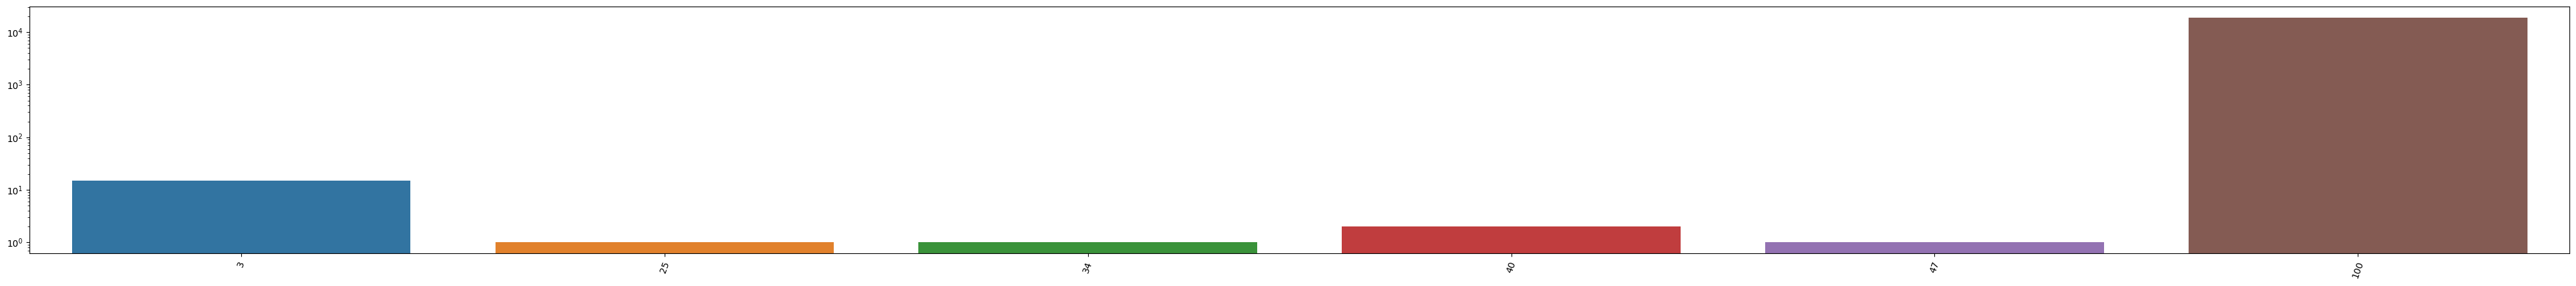

In [59]:
fig, ax = plt.subplots(figsize=(50, 5), dpi=100)
sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=ax)
plt.xticks(rotation=70)
plt.yscale('log')
plt.show()

Se eliminan los articulos de tamano menor a 100

In [143]:
sanitized = [s if s and len(s) > 500 else None for s in sanitized]
sum(1 for s in sanitized if s is not None)/len(sanitized)

0.9389